<a href="https://colab.research.google.com/github/nischaya25/Trader-Behavior-vs-Market-Sentiment/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

**Predict next-day trader profitability bucket or volatility of PnL using sentiment + behavior features**



In [ ]:
merged_df = pd.read_csv('/content/processed_trader_data (6).csv')
print('Columns in merged_df:', merged_df.columns)
daily_features = merged_df.groupby(['Account','date']).agg({
    'Closed PnL':'sum',
    'Size USD':'mean',
    'win':'mean',
    'classification':'first'
}).reset_index()

daily_features.rename(columns={
    'Closed PnL':'daily_pnl',
    'Size USD':'avg_size',
    'win':'win_rate'
}, inplace=True)

Columns in merged_df: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'datetime', 'win', 'date', 'timestamp', 'value',
       'classification', 'Trade Category'],
      dtype='object')


In [ ]:
daily_features['next_day_pnl'] = (
    daily_features.groupby('Account')['daily_pnl'].shift(-1)
)

In [ ]:
daily_features['profit_bucket'] = np.where(
    daily_features['next_day_pnl'] > 0,
    'Profitable',
    'Not Profitable'
)

In [ ]:
daily_features.dropna(inplace=True)

In [ ]:
le = LabelEncoder()
daily_features['sentiment_encoded'] = le.fit_transform(
    daily_features['classification']
)

In [ ]:
X = daily_features.drop(['Account', 'date', 'next_day_pnl', 'profit_bucket', 'classification'], axis=1)
y = daily_features['profit_bucket']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:


-preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy: 0.6471861471861472
                precision    recall  f1-score   support

Not Profitable       0.54      0.40      0.46       174
    Profitable       0.69      0.80      0.74       288

      accuracy                           0.65       462
     macro avg       0.61      0.60      0.60       462
  weighted avg       0.63      0.65      0.63       462



**Clustering Traders (Behavioral Archetypes)**

In [ ]:
trader_features = merged_df.groupby('Account').agg({
    'Closed PnL':'mean',
    'Size USD':'mean',
    'win':'mean'
}).reset_index()

trader_features.columns = [
    'account',
    'avg_pnl',
    'avg_size',
    'win_rate'
]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(
    trader_features[['avg_pnl','avg_size','win_rate']]
)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled)

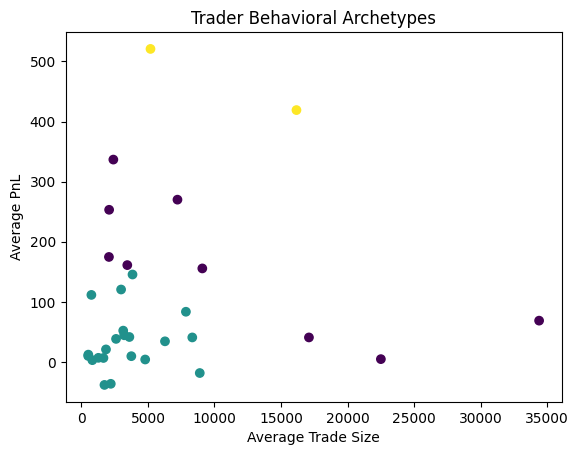

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    trader_features['avg_size'],
    trader_features['avg_pnl'],
    c=trader_features['cluster']
)

plt.xlabel("Average Trade Size")
plt.ylabel("Average PnL")
plt.title("Trader Behavioral Archetypes")
plt.show()

In [ ]:
from google.colab import files

merged_df.to_csv("processed_trader_data.csv", index=False)
files.download("processed_trader_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>